## Run this tutorial with the **nnpcg_ana** environment

### Importing libraries

In [2]:
import matplotlib
from htmd.ui import *
import seaborn as sns
import matplotlib.pyplot as plt
from nnpcg.analyzer import EasyAnalyzer
from nnpcg.analyzer import sample_state, build_backbone

In [ ]:
# modify the next variable with the path to the folder where you cloned the repository
path_to_repo = '/home/dpastor/Dropbox (Biocomputing)/GitHub/projects/nnpcg'

# defining the path to the analysis folder
analysis_data_folder = os.path.join(path_to_repo, 'nnpcg/data/analysis')

analysis_test = EasyAnalyzer(refmodel=os.path.join(analysis_data_folder, 'proteing_1mi0.pdb'), reftic=os.path.join(analysis_data_folder, 'proteing_TICA_lag20_CAdist_skip1.dat'), refmodel=os.path.join(analysis_data_folder, 'proteing_model_lag10ns_1200k_4ticadim_CAdist_skip1.dat'))


/home/dpastor/Dropbox (Biocomputing)/GitHub/projects/nnpcg/nnpcg/analyzer.py:214: RuntimeWarning: divide by zero encountered in log
  energy = np.where(counts != 0, -Kinetics._kB * 350 * np.log(counts), counts)


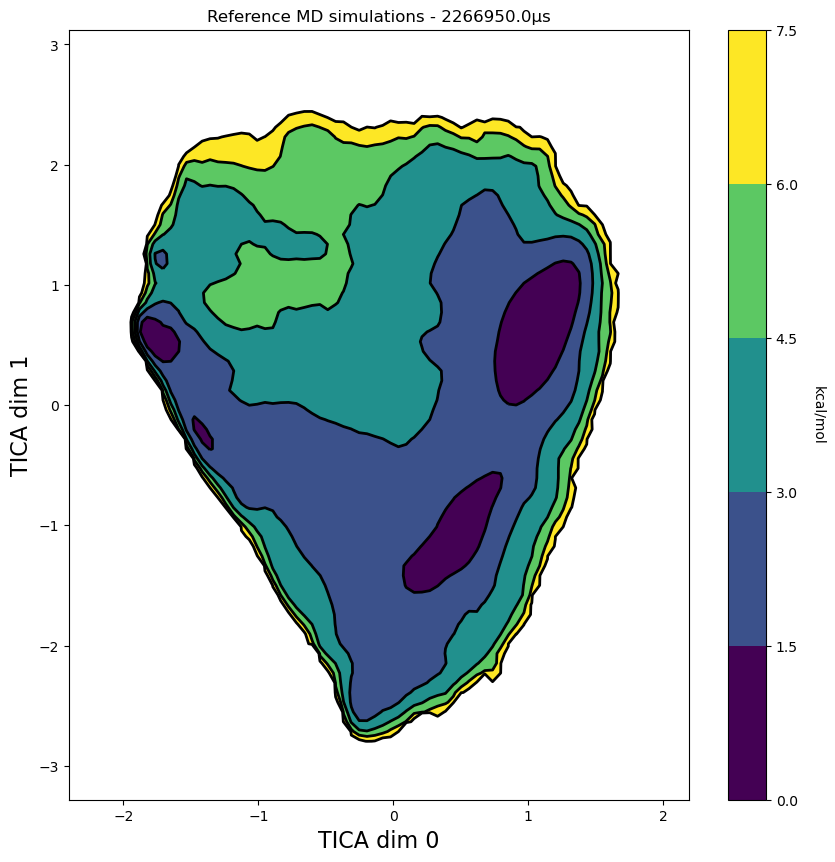

In [ ]:
analysis_test.plot_ref_tic()

In [ ]:
psf_file = os.path.join(analysis_data_folder, 'proteing_ca_top_dih.psf')
pdb_file = os.path.join(analysis_data_folder, 'proteing_ca_top_dih.pdb')
sims = simlist(glob(analysis_data_folder + 'proteing_32trajs_250_ts1/*'), pdb_file)

Creating simlist: 100%|██████████| 32/32 [00:00<00:00, 45.88it/s]


In [ ]:
skip = 2
metr = Metric(sims, skip=skip)
metr.set(MetricSelfDistance('all', periodic=None))
data = metr.project()
data.fstep = 0.0001 * skip

/home/dpastor/Documents/programs/anaconda3/envs/nnpcg_ana/lib/python3.9/site-packages/htmd/projections/metric.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pandamap = pandamap.append(proj.getMapping(mol), ignore_index=True)
Projecting trajectories:   0%|          | 0/32 [00:00<?, ?it/s]/home/dpastor/Documents/programs/anaconda3/envs/nnpcg_ana/lib/python3.9/site-packages/moleculekit/readers.py:1560: RuntimeWarning: overflow encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
/home/dpastor/Documents/programs/anaconda3/envs/nnpcg_ana/lib/python3.9/site-packages/moleculekit/readers.py:1560: RuntimeWarning: invalid value encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
Projecting trajectories: 100%|██████████| 32/32 [01:48<00:00,  3.39s/it]
/home/dpastor/Documents/programs/anaconda3/envs/nnpcg_ana/lib/python3.9/site-packages/htmd/projections/metric.py:204: Fu

In [ ]:
ticadim = 3
init_frames = 0.1
reftic.set_params(dim=ticadim)
datatica = reftic.transform(np.concatenate([line[int(line.shape[0] * init_frames):] for line in data.dat]))
datatica = MetricData(dat=datatica.reshape(len(data.simlist), -1, ticadim), simlist=data.simlist, fstep=data.fstep)

In [ ]:
nclust = 200
datatica.cluster(MiniBatchKMeans(nclust))

In [ ]:
macronum = 4
lag = 0.01
cgmodel = Model(datatica)
cgmodel.markovModel(lag, macronum, units='ns')
cgweights = computeWeights(cgmodel)

In [ ]:
cgmodel.plotTimescales(maxlag=0.1, units='ns')

In [ ]:
levels = np.arange(0, 7.6, 1.5)
cmap = 'viridis'
dimx, dimy = 0,1
states = list(range(cgmodel.macronum))[::-1]
refstates = list(range(refmodel.macronum))[::-1]

fig, ax = plt.subplots(ncols=2, figsize=[26,11])

plt.sca(ax[0])
plotContour(np.concatenate(cgmodel.data.dat), cgweights, levels, dimx=dimx, dimy=dimy, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.tick_params() 
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('kcal/mol', rotation=270)
# plotstates(cgmodel, states=states, dimx=dimx, dimy=dimy, cmap='tab20')
# plt.legend(fontsize=14, bbox_to_anchor=(1.15, 1), loc='upper left')
plt.xlabel(f'TICA dim {dimx}', size=16)
plt.ylabel(f'TICA dim {dimy}', size=16)
plt.title('CG simulations- {:.1f}µs'.format(np.concatenate(cgmodel.data.dat).shape[0] * 0.002))


plt.sca(ax[1])
plotContour(np.concatenate(refmodel.data.dat), mweights, levels, dimx=dimx, dimy=dimy, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.tick_params() 
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('kcal/mol', rotation=270)
# plotstates(refmodel, states=refstates, dimx=dimx, dimy=dimy, cmap='tab20')
# plt.legend(fontsize=14, bbox_to_anchor=(1.15, 1), loc='upper left')
plt.xlabel(f'TICA dim {dimx}', size=16)
plt.ylabel(f'TICA dim {dimy}', size=16)
plt.title('Reference MD simulations - {:.1f}µs'.format(np.concatenate(refmodel.data.dat).shape[0] * 0.1))
plt.show()

In [ ]:
def get1dtica(data, weights, bins=120, dim=0):
    counts, bins = np.histogram(data[:,dim], bins=bins, weights=weights)
    energy =  -Kinetics._kB*300*np.log(counts)
    ecorr = np.min(energy[energy!=0])
    energy = energy - ecorr
    return energy, bins

bins=120
ref_energy, ref_bins = get1dtica(np.concatenate(refmodel.data.dat), mweights, bins=bins)
cg_energy, cg_bins = get1dtica(np.concatenate(cgmodel.data.dat), cgweights, bins=bins)
crystal_dist = MetricSelfDistance('name CA', pbc=None).project(refmol)
reftic.set_params(dim=3)
tica_crystal = reftic.transform(crystal_dist).flatten()

plt.figure(figsize=[8,8])
sns.lineplot(x=ref_bins[:-1], y=ref_energy, label='Ref', alpha=0.5)
plt.fill_between(ref_bins[:-1], ref_energy, alpha=0.3)
sns.lineplot(x=cg_bins[:-1], y=cg_energy, label='CG', color='lightgreen')
plt.fill_between(cg_bins[:-1], cg_energy, alpha=0.3, color='lightgreen')
plt.scatter(tica_crystal[0], -0.15, s=40, marker='|', c='red', label='Crystal')

plt.xlabel(f'TIC 1')
plt.ylabel(f'Free energy (kcal/mol)')
plt.title(f'1D TICA')
plt.legend(loc='upper center')
plt.show()

In [ ]:
sns.set_context('poster')
xlim0, xlim1, ylim0, ylim1 = [-2, 2, -3.1, 2.9]
levels = [0, 2.5, 5, 7.5]
trajectory = 14
#plot TICA


plotContour(np.concatenate(cgmodel.data.dat), weights=cgweights, 
                levels=levels, cmap='gray')
clb = plt.colorbar()
clb.set_label('kcal/mol', rotation=90)
plt.axis('equal')
plt.grid(alpha=0.5)
plt.xlim([xlim0, xlim1])
plt.ylim([ylim0, ylim1])
plt.xlabel('TIC1')
plt.ylabel('TIC2')
plotContour(np.concatenate(refmodel.data.dat), weights=mweights, fill = False, levels=levels, cmap='Greys_r', 
            colors='red', alpha = 0.5)

plt.title(f'Protein G - Trajectory {trajectory}\n')

mol = Molecule(psf_file)
mol.read(analysis_data_folder = 'proteing_32trajs_250_ts1/traj_{trajectory}/traj_{trajectory}.xtc')

mol_dist = MetricSelfDistance('name CA', pbc=None).project(mol)
tica_mol = reftic.transform(mol_dist)

skip = int(tica_mol.shape[0]/100)
cmap = matplotlib.cm.get_cmap('viridis')
segments_x = np.stack((tica_mol[::skip,0][:-1], tica_mol[::skip,0][1:]))
segments_y = np.stack((tica_mol[::skip,1][:-1], tica_mol[::skip,1][1:]))
nsegs = segments_x.shape[1]

plt.plot(segments_x, segments_y, c='white', linewidth = 2.5)
for i in range(nsegs):
    plt.plot(segments_x[:, i], segments_y[:, i], c=cmap(i/nsegs), linewidth = 2)
plt.show() 

#plot RMSD

metr = MetricRmsd(refmol, 'name CA', pbc=False)
rmsd = metr.project(mol)
ts = 0.0001
time = np.arange(0, rmsd.shape[0]*ts, ts)
#     plt.plot(time, rmsd, c='r')

for i in range(nsegs):
    if i == nsegs-1:
        plt.plot(time[i*skip:], rmsd[i*skip:], c=cmap(i/nsegs))
    else:
        plt.plot(time[i*skip:(i+1)*skip+1], rmsd[i*skip:(i+1)*skip+1], c=cmap(i/nsegs))

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.grid(visible=True)
plt.xlim([0, rmsd.shape[0]*ts])
plt.show()
sns.reset_orig()

In [ ]:
ref_selmacro = [3,2,1,0]
ref_molsampl = refmodel.sampleStates(states=ref_selmacro, samplemode='random', frames=50)[1]

In [ ]:
cg_selmacro = [3,2,1,0]
for macro in cg_selmacro:
    ref = ref_molsampl[macro][-1]
    simid = refmodel.data.simlist[ref[0]]
    refmol = Molecule(simid.molfile)
    refmol.read(simid.trajectory[0], frames=ref[1])
    mol, molsampl = sample_state(cgmodel, macro, 'macro')
    samples_rmsd = MetricRmsd(refmol, 'name CA', pbc=False).project(mol)
    bbmol = build_backbone(mol, refmol)
#   bbmol.write(f'Tutorial-files/proteing_CG_macrosample_M{macro}.pdb')
#   bbmol.write(f'Tutorial-files/proteing_CG_macrosample_M{macro}.xtc')

In [ ]:
ss_elems = {'B1': [0,7],
            'B2': [12,19],
            'B3': [41,45],
            'B4': [49,53],
            'H':  [22,36]}

refmol_CA = refmol.copy()
refmol_CA.filter('name CA')

helix_rmsd = []
sheet12_rmsd = []
sheet34_rmsd = []
sheet14_rmsd = []

for macro in range(cgmodel.macronum):
    mol = Molecule(analysis_data_folder + 'proteing_CG_macrostate_samples/proteing_CG_macrosample_M{macro}.pdb')
    mol.read(analysis_data_folder + 'proteing_CG_macrostate_samples/proteing_CG_macrosample_M{macro}.xtc')
    mol.filter('name CA', _logger=False)
    
    #helix
    trajrmsdstr = f'resid {mol.resid[ss_elems["H"][0]]} to {mol.resid[ss_elems["H"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["H"][0]]} to {refmol_CA.resid[ss_elems["H"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    helix_rmsd.append(metr.project(mol))
    
    #1-2 hairpin
    trajrmsdstr = f'resid {mol.resid[ss_elems["B1"][0]]} to {mol.resid[ss_elems["B1"][1]]} or resid {mol.resid[ss_elems["B2"][0]]} to {mol.resid[ss_elems["B2"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["B1"][0]]} to {refmol_CA.resid[ss_elems["B1"][1]]} or resid {refmol_CA.resid[ss_elems["B2"][0]]} to {refmol_CA.resid[ss_elems["B2"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    sheet12_rmsd.append(metr.project(mol))
    
    #3-4 haipin 
    trajrmsdstr = f'resid {mol.resid[ss_elems["B3"][0]]} to {mol.resid[ss_elems["B3"][1]]} or resid {mol.resid[ss_elems["B4"][0]]} to {mol.resid[ss_elems["B4"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["B3"][0]]} to {refmol_CA.resid[ss_elems["B3"][1]]} or resid {refmol_CA.resid[ss_elems["B4"][0]]} to {refmol_CA.resid[ss_elems["B4"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    sheet34_rmsd.append(metr.project(mol))
    
    #1-4 hairpin
    trajrmsdstr = f'resid {mol.resid[ss_elems["B1"][0]]} to {mol.resid[ss_elems["B1"][1]]} or resid {mol.resid[ss_elems["B4"][0]]} to {mol.resid[ss_elems["B4"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["B1"][0]]} to {refmol_CA.resid[ss_elems["B1"][1]]} or resid {refmol_CA.resid[ss_elems["B4"][0]]} to {refmol_CA.resid[ss_elems["B4"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    sheet14_rmsd.append(metr.project(mol))
    
helix_rmsd = np.array(helix_rmsd)
sheet12_rmsd = np.array(sheet12_rmsd)
sheet34_rmsd = np.array(sheet34_rmsd)
sheet14_rmsd = np.array(sheet14_rmsd)